In [1]:
import fasttext
import pandas as pd
import spacy
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
stopword = set(stopwords.words('english'))
stemmer = nltk.SnowballStemmer("english")

df = pd.read_csv("C:\\Users\\Admin\\Downloads\\twitter_data.csv")
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [2]:
#nlp = spacy.load("en_core_web_lg")
nlp = spacy.load("en_core_web_lg", disable=["tagger"])

In [3]:
df["labels"] = df['class'].map({0: "Hate_Speech", 1: "Offensive_Speech", 2: "No_Hate_and_Offensive_Speech"})
df = df[["tweet", "labels"]]

def preprocess(text):
    test_list = text.split()
    text = ""
    for word in test_list:
        if word.endswith("ing"):
            word = word[:-3]
        text += word
        text += " "
    doc = nlp(text)
    filtered_tokens = []

    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    return " ".join(filtered_tokens)

'''def preprocess(text):
    # Tokenize text
    tokens = nltk.word_tokenize(text)

    filtered_tokens = []
    for token in tokens:
        # Remove words ending with "ing"
        if token.endswith("ing"):
            token = token[:-3]

        # Remove punctuation
        token = re.sub(r'[^\w\s]', '', token)

        # Convert to lowercase
        token = token.lower()

        # Lemmatize token
        token = lemmatizer.lemmatize(token)

        # Filter out stop words and single-character tokens
        if token not in stopword and len(token) > 1:
            filtered_tokens.append(token)

    return " ".join(filtered_tokens)
'''

df["tweet_new"] = df.tweet.apply(preprocess)

def clean(text):
    text = str(text).lower()
    text = re.sub('[.?]', '', text)
    text = re.sub('https?://\S+|www.\S+', '', text)
    text = re.sub('<.?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w\d\w', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text = " ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text = " ".join(text)
    return text

df["tweet_new"] = df.tweet_new.apply(clean)
df['labels'] = '__label__' + df['labels'].astype(str)
df['category_description'] = df['labels'] + ' ' + df['tweet_new']

C:\Users\Admin\anaconda3\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [4]:
# saving the dataframe
df.to_csv('hate_with_tweet_new.csv')

In [5]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['tweet_new'], df['labels'], test_size=0.2, random_state=42)

# Train a FastText model
model = fasttext.train_supervised(input="hate-correct.train")

# Get FastText embeddings for the training and testing data
X_train_fasttext = [model.get_sentence_vector(text) for text in X_train]
X_test_fasttext = [model.get_sentence_vector(text) for text in X_test]

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [6]:
# Save fasttext
import joblib
fasttext_model_path = "fasttext_model.bin"
model.save_model(fasttext_model_path)

In [6]:
# Train an SVM classifier using FastText features
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_fasttext, y_train_encoded)
#Save SVM 
svm_model_path = "svm_model.joblib"
#joblib.dump(svm_classifier, svm_model_path)
# Evaluate SVM classifier
svm_accuracy = svm_classifier.score(X_test_fasttext, y_test_encoded)
print("SVM Accuracy:", svm_accuracy)

'''# Predict with SVM
txt = "hi bro"
txt = preprocess(txt)
txt_fasttext = model.get_sentence_vector(txt)
svm_prediction = svm_classifier.predict([txt_fasttext])
print("SVM Prediction:", label_encoder.inverse_transform(svm_prediction))'''

SVM Accuracy: 0.9445228969134557


'# Predict with SVM\ntxt = "hi bro"\ntxt = preprocess(txt)\ntxt_fasttext = model.get_sentence_vector(txt)\nsvm_prediction = svm_classifier.predict([txt_fasttext])\nprint("SVM Prediction:", label_encoder.inverse_transform(svm_prediction))'

SVM Accuracy: 0.9445228969134557
SVM F1 Score: 0.9390660088419404
SVM Precision: 0.9406405687091256
SVM Recall: 0.9445228969134557
SVM AUC Scores per class: 0.9515895996475401
SVM Confusion Matrix:
[[ 125   12  153]
 [   4  799   32]
 [  26   48 3758]]


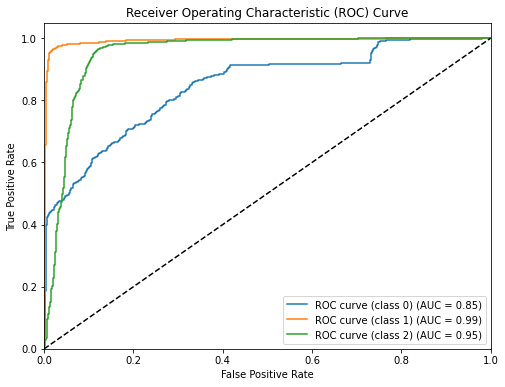

In [7]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# Calculate accuracy
svm_accuracy = accuracy_score(y_test_encoded, svm_classifier.predict(X_test_fasttext))
print("SVM Accuracy:", svm_accuracy)

# Calculate F1 score
svm_f1_score = f1_score(y_test_encoded, svm_classifier.predict(X_test_fasttext), average='weighted')
print("SVM F1 Score:", svm_f1_score)

# Calculate precision
svm_precision = precision_score(y_test_encoded, svm_classifier.predict(X_test_fasttext), average='weighted')
print("SVM Precision:", svm_precision)

# Calculate recall
svm_recall = recall_score(y_test_encoded, svm_classifier.predict(X_test_fasttext), average='weighted')
print("SVM Recall:", svm_recall)

# Calculate AUC score
from sklearn.metrics import roc_auc_score, auc

from sklearn.preprocessing import label_binarize

# Binarize the test labels
y_test_binarized = label_binarize(y_test_encoded, classes=range(len(label_encoder.classes_)))

# Calculate ROC AUC score for each class separately
y_score = svm_classifier.decision_function(X_test_fasttext)
svm_auc_scores = roc_auc_score(y_test_binarized, y_score, average='weighted', multi_class='ovr')
print("SVM AUC Scores per class:", svm_auc_scores)

# Calculate confusion matrix
svm_conf_matrix = confusion_matrix(y_test_encoded, svm_classifier.predict(X_test_fasttext))
print("SVM Confusion Matrix:")
print(svm_conf_matrix)

from sklearn.metrics import roc_curve

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {0}) (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [8]:
#Save SVM 
svm_model_path = "svm_model.joblib"
joblib.dump(svm_classifier, svm_model_path)

['svm_model.joblib']

In [8]:
import joblib
# Load the FastText model
fasttext_model_path = "fasttext_model.bin"
fasttext_model = fasttext.load_model(fasttext_model_path)

# Load the ensemble model
svm_model_path = "svm_model.joblib"
svm_model = joblib.load(svm_model_path)

# Predict with SVM
txt = "hi bro"
txt = preprocess(txt)
txt_fasttext = fasttext_model.get_sentence_vector(txt)
svm_prediction = svm_model.predict([txt_fasttext])
print("SVM Prediction:", label_encoder.inverse_transform(svm_prediction))

SVM Prediction: ['__label__No_Hate_and_Offensive_Speech']


C:\Users\Admin\anaconda3\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [8]:
# Train a Random Forest classifier using FastText features
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_fasttext, y_train_encoded)
# Evaluate Random Forest classifier
rf_accuracy = rf_classifier.score(X_test_fasttext, y_test_encoded)
print("Random Forest Accuracy:", rf_accuracy)

'''# Predict with Random Forest
rf_prediction = rf_classifier.predict([txt_fasttext])
print("Random Forest Prediction:", label_encoder.inverse_transform(rf_prediction))'''

Random Forest Accuracy: 0.9441194270728263


'# Predict with Random Forest\nrf_prediction = rf_classifier.predict([txt_fasttext])\nprint("Random Forest Prediction:", label_encoder.inverse_transform(rf_prediction))'

In [10]:
#Save RF
rf_model_path = "rf_model.joblib"
joblib.dump(rf_classifier, rf_model_path)

['rf_model.joblib']

Random Forest Accuracy: 0.9441194270728263
Random Forest F1 Score: 0.9409940535507411
Random Forest Precision: 0.9403247950442176
Random Forest Recall: 0.9441194270728263
Random Forest AUC Scores per class: 0.9714803098482572
Random Forest Confusion Matrix:
[[ 150    8  132]
 [  10  787   38]
 [  43   46 3743]]


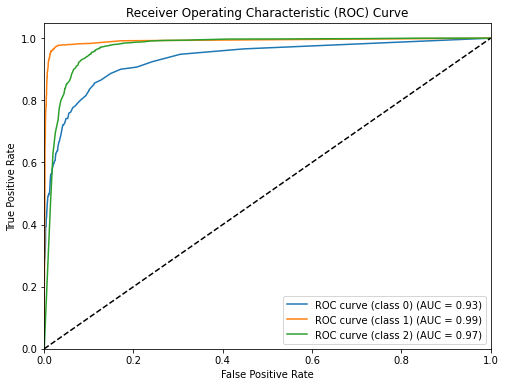

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# Calculate accuracy
rf_accuracy = accuracy_score(y_test_encoded, rf_classifier.predict(X_test_fasttext))
print("Random Forest Accuracy:", rf_accuracy)

# Calculate F1 score
rf_f1_score = f1_score(y_test_encoded, rf_classifier.predict(X_test_fasttext), average='weighted')
print("Random Forest F1 Score:", rf_f1_score)

# Calculate precision
rf_precision = precision_score(y_test_encoded, rf_classifier.predict(X_test_fasttext), average='weighted')
print("Random Forest Precision:", rf_precision)

# Calculate recall
rf_recall = recall_score(y_test_encoded, rf_classifier.predict(X_test_fasttext), average='weighted')
print("Random Forest Recall:", rf_recall)

# Calculate AUC score
from sklearn.metrics import roc_auc_score, auc

from sklearn.preprocessing import label_binarize

# Binarize the test labels
y_test_binarized = label_binarize(y_test_encoded, classes=range(len(label_encoder.classes_)))

# Calculate ROC AUC score for each class separately
y_score = rf_classifier.predict_proba(X_test_fasttext)
rf_auc_scores = roc_auc_score(y_test_binarized, y_score, average='weighted', multi_class='ovr')
print("Random Forest AUC Scores per class:", rf_auc_scores)

# Calculate confusion matrix
rf_conf_matrix = confusion_matrix(y_test_encoded, rf_classifier.predict(X_test_fasttext))
print("Random Forest Confusion Matrix:")
print(rf_conf_matrix)

from sklearn.metrics import roc_curve

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {0}) (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [10]:
from sklearn.tree import DecisionTreeClassifier

model1 = DecisionTreeClassifier()
model1.fit(X_train_fasttext, y_train_encoded)
# Evaluate Random Forest classifier
accuracy = model1.score(X_test_fasttext, y_test_encoded)
print("Decision tree Accuracy:", accuracy)

'''# Predict with Random Forest
model_prediction = model1.predict([txt_fasttext])
print("Decision Prediction:", label_encoder.inverse_transform(model_prediction))'''

Decision tree Accuracy: 0.9070002017349204


'# Predict with Random Forest\nmodel_prediction = model1.predict([txt_fasttext])\nprint("Decision Prediction:", label_encoder.inverse_transform(model_prediction))'

Decision Tree Accuracy: 0.9070002017349204
Decision Tree F1 Score: 0.9076352957315864
Decision Tree Precision: 0.9083084641479164
Decision Tree Recall: 0.9070002017349204
Decision Tree AUC Scores per class: 0.879146539486093
Decision Tree Confusion Matrix:
[[ 138   13  139]
 [  24  741   70]
 [ 142   73 3617]]


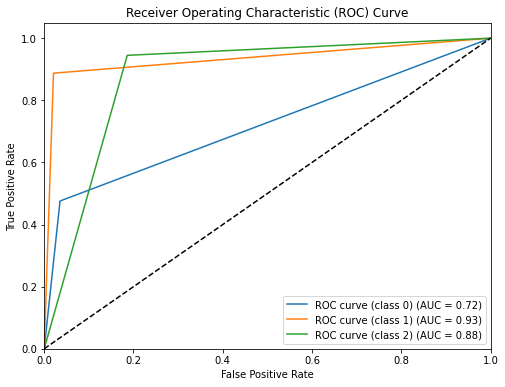

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# Calculate accuracy
dt_accuracy = accuracy_score(y_test_encoded, model1.predict(X_test_fasttext))
print("Decision Tree Accuracy:", dt_accuracy)

# Calculate F1 score
dt_f1_score = f1_score(y_test_encoded, model1.predict(X_test_fasttext), average='weighted')
print("Decision Tree F1 Score:", dt_f1_score)

# Calculate precision
dt_precision = precision_score(y_test_encoded, model1.predict(X_test_fasttext), average='weighted')
print("Decision Tree Precision:", dt_precision)

# Calculate recall
dt_recall = recall_score(y_test_encoded, model1.predict(X_test_fasttext), average='weighted')
print("Decision Tree Recall:", dt_recall)

# Calculate AUC score
from sklearn.metrics import roc_auc_score, auc

# Calculate ROC AUC score for each class separately
y_score = model1.predict_proba(X_test_fasttext)
dt_auc_scores = roc_auc_score(y_test_binarized, y_score, average='weighted', multi_class='ovr')
print("Decision Tree AUC Scores per class:", dt_auc_scores)

# Calculate confusion matrix
dt_conf_matrix = confusion_matrix(y_test_encoded, model1.predict(X_test_fasttext))
print("Decision Tree Confusion Matrix:")
print(dt_conf_matrix)

from sklearn.metrics import roc_curve

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {0}) (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression()
model1.fit(X_train_fasttext, y_train_encoded)
# Evaluate Random Forest classifier
accuracy = model1.score(X_test_fasttext, y_test_encoded)
print("Logistic Regression Accuracy:", accuracy)

'''# Predict with Logistic Regression
model_prediction = model1.predict([txt_fasttext])
print("Logistic Regression Prediction:", label_encoder.inverse_transform(model_prediction))'''

Logistic Regression Accuracy: 0.9441194270728263


'# Predict with Logistic Regression\nmodel_prediction = model1.predict([txt_fasttext])\nprint("Logistic Regression Prediction:", label_encoder.inverse_transform(model_prediction))'

In [13]:
#Save LR
lr_model_path = "lr_model.joblib"
joblib.dump(model1, lr_model_path)

['lr_model.joblib']

Logistic Regression Accuracy: 0.9441194270728263
Logistic Regression F1 Score: 0.9397017558293467
Logistic Regression Precision: 0.9399789964656996
Logistic Regression Recall: 0.9441194270728263
Logistic Regression AUC Scores per class: 0.9740587459016589
Logistic Regression Confusion Matrix:
[[ 135   14  141]
 [   3  797   35]
 [  37   47 3748]]


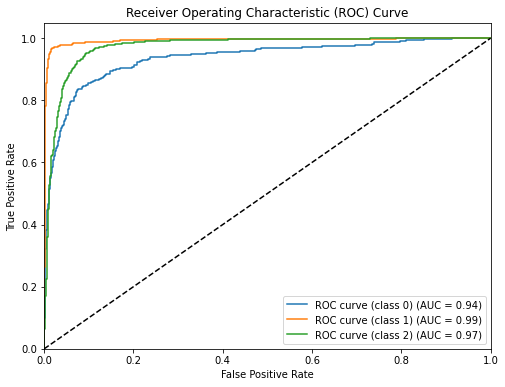

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# Calculate accuracy
lr_accuracy = accuracy_score(y_test_encoded, model1.predict(X_test_fasttext))
print("Logistic Regression Accuracy:", lr_accuracy)

# Calculate F1 score
lr_f1_score = f1_score(y_test_encoded, model1.predict(X_test_fasttext), average='weighted')
print("Logistic Regression F1 Score:", lr_f1_score)

# Calculate precision
lr_precision = precision_score(y_test_encoded, model1.predict(X_test_fasttext), average='weighted')
print("Logistic Regression Precision:", lr_precision)

# Calculate recall
lr_recall = recall_score(y_test_encoded, model1.predict(X_test_fasttext), average='weighted')
print("Logistic Regression Recall:", lr_recall)

# Calculate AUC score
from sklearn.metrics import roc_auc_score, auc

# Calculate ROC AUC score for each class separately
y_score = model1.predict_proba(X_test_fasttext)
lr_auc_scores = roc_auc_score(y_test_binarized, y_score, average='weighted', multi_class='ovr')
print("Logistic Regression AUC Scores per class:", lr_auc_scores)

# Calculate confusion matrix
lr_conf_matrix = confusion_matrix(y_test_encoded, model1.predict(X_test_fasttext))
print("Logistic Regression Confusion Matrix:")
print(lr_conf_matrix)

from sklearn.metrics import roc_curve

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {0}) (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [9]:
from sklearn.naive_bayes import MultinomialNB
model1 = MultinomialNB()
model1.fit(X_train_fasttext, y_train_encoded)
# Evaluate Random Forest classifier
accuracy = model1.score(X_test_fasttext, y_test_encoded)
print("Naive Accuracy:", accuracy)
# Predict with Random Forest
model_prediction = model1.predict([txt_fasttext])
print("Random Forest Prediction:", label_encoder.inverse_transform(model_prediction))

ValueError: Negative values in data passed to MultinomialNB (input X)

In [14]:
from sklearn.neighbors import KNeighborsClassifier

model1 = KNeighborsClassifier(n_neighbors=5)
model1.fit(X_train_fasttext, y_train_encoded)
# Evaluate Random Forest classifier
accuracy = model1.score(X_test_fasttext, y_test_encoded)
print("Naive Accuracy:", accuracy)

'''# Predict with Random Forest
model_prediction = model1.predict([txt_fasttext])
print("Naive Prediction:", label_encoder.inverse_transform(model_prediction))'''

Naive Accuracy: 0.9419003429493645


'# Predict with Random Forest\nmodel_prediction = model1.predict([txt_fasttext])\nprint("Naive Prediction:", label_encoder.inverse_transform(model_prediction))'

K Nearest Neighbor Accuracy: 0.9419003429493645
K Nearest Neighbor F1 Score: 0.9393015928278305
K Nearest Neighbor Precision: 0.938253618834012
K Nearest Neighbor Recall: 0.9419003429493645
K Nearest Neighbor AUC Scores per class: 0.9496313375570736
K Nearest Neighbor Confusion Matrix:
[[ 153    6  131]
 [  11  790   34]
 [  54   52 3726]]


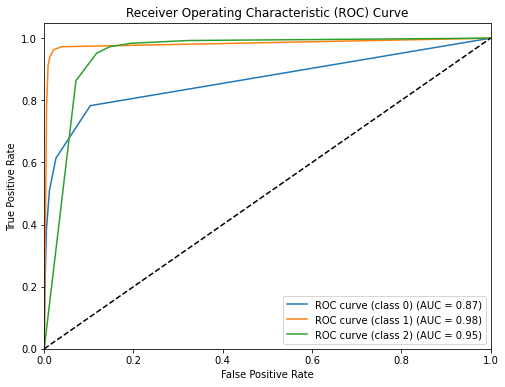

In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# Calculate accuracy
kn_accuracy = accuracy_score(y_test_encoded, model1.predict(X_test_fasttext))
print("K Nearest Neighbor Accuracy:", kn_accuracy)

# Calculate F1 score
kn_f1_score = f1_score(y_test_encoded, model1.predict(X_test_fasttext), average='weighted')
print("K Nearest Neighbor F1 Score:", kn_f1_score)

# Calculate precision
kn_precision = precision_score(y_test_encoded, model1.predict(X_test_fasttext), average='weighted')
print("K Nearest Neighbor Precision:", kn_precision)

# Calculate recall
kn_recall = recall_score(y_test_encoded, model1.predict(X_test_fasttext), average='weighted')
print("K Nearest Neighbor Recall:", kn_recall)

# Calculate AUC score
from sklearn.metrics import roc_auc_score, auc

# Calculate ROC AUC score for each class separately
y_score = model1.predict_proba(X_test_fasttext)
kn_auc_scores = roc_auc_score(y_test_binarized, y_score, average='weighted', multi_class='ovr')
print("K Nearest Neighbor AUC Scores per class:", kn_auc_scores)

# Calculate confusion matrix
kn_conf_matrix = confusion_matrix(y_test_encoded, model1.predict(X_test_fasttext))
print("K Nearest Neighbor Confusion Matrix:")
print(kn_conf_matrix)

from sklearn.metrics import roc_curve

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {0}) (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [16]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Define individual models
decision_tree_model = DecisionTreeClassifier()
random_forest_model = RandomForestClassifier()
svm_model = SVC(kernel='linear', probability=True)  # Enable probability estimation for SVM

# Define the ensemble of models
ensemble_model = VotingClassifier(estimators=[
    ('decision_tree', decision_tree_model),
    ('random_forest', random_forest_model),
    ('svm', svm_model)
], voting='soft')  # Use soft voting for probability averaging

# Training the ensemble model
ensemble_model.fit(X_train_fasttext, y_train_encoded)

# Testing the ensemble model
y_pred_ensemble = ensemble_model.predict(X_test_fasttext)

# Accuracy Score of ensemble model
accuracy_ensemble = accuracy_score(y_test_encoded, y_pred_ensemble)
print("Ensemble Accuracy Score:", accuracy_ensemble)

Ensemble Accuracy Score: 0.9370587048618115


Ensemble Model Accuracy: 0.9370587048618115
Ensemble Model F1 Score: 0.9340299130909968
Ensemble Model Precision: 0.9327114897695398
Ensemble Model Recall: 0.9370587048618115
Ensemble Model AUC Scores per class: 0.9723379776905849
Ensemble Model Confusion Matrix:
[[ 142   12  136]
 [   9  788   38]
 [  62   55 3715]]


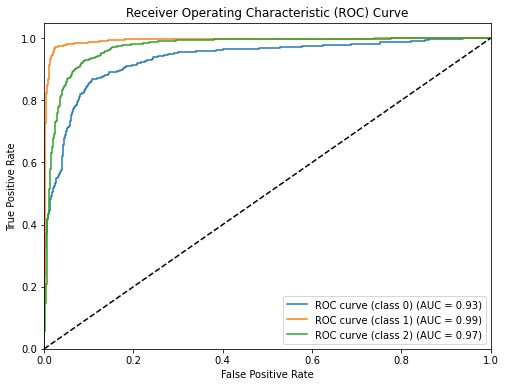

In [17]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# Calculate accuracy
en_accuracy = accuracy_score(y_test_encoded, ensemble_model.predict(X_test_fasttext))
print("Ensemble Model Accuracy:", en_accuracy)

# Calculate F1 score
en_f1_score = f1_score(y_test_encoded, ensemble_model.predict(X_test_fasttext), average='weighted')
print("Ensemble Model F1 Score:", en_f1_score)

# Calculate precision
en_precision = precision_score(y_test_encoded, ensemble_model.predict(X_test_fasttext), average='weighted')
print("Ensemble Model Precision:", en_precision)

# Calculate recall
en_recall = recall_score(y_test_encoded, ensemble_model.predict(X_test_fasttext), average='weighted')
print("Ensemble Model Recall:", en_recall)

# Calculate AUC score
from sklearn.metrics import roc_auc_score, auc

# Calculate ROC AUC score for each class separately
y_score = ensemble_model.predict_proba(X_test_fasttext)
en_auc_scores = roc_auc_score(y_test_binarized, y_score, average='weighted', multi_class='ovr')
print("Ensemble Model AUC Scores per class:", en_auc_scores)

# Calculate confusion matrix
en_conf_matrix = confusion_matrix(y_test_encoded, ensemble_model.predict(X_test_fasttext))
print("Ensemble Model Confusion Matrix:")
print(en_conf_matrix)

from sklearn.metrics import roc_curve

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {0}) (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Get input from the user
user_input = input("Enter the text you want to classify: ")

# Preprocess the user input
user_input_processed = preprocess(user_input)

# Transform the preprocessed input using the FastText model to get embeddings
user_input_embedding = model.get_sentence_vector(user_input_processed)

# Make prediction using the ensemble model
prediction = ensemble_model.predict([user_input_embedding])

# Convert the predicted label back to its original form
predicted_label = label_encoder.inverse_transform(prediction)[0]

# Print the predicted label
print("Predicted label:", predicted_label)

In [3]:
spacy_model_name = "en_core_web_lg"
if spacy_model_name in spacy.util.get_installed_models():
    print("hi")

hi
